In [ ]:
import cv2
import numpy as np
import string as st


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Mar 17 18:32:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Download darknet**




In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 14730, done.
remote: Total 14730 (delta 0), reused 0 (delta 0), pack-reused 14730
Receiving objects: 100% (14730/14730), 13.27 MiB | 24.62 MiB/s, done.
Resolving deltas: 100% (10020/10020), done.


**Compile darknet with NVIDIA GPU**

In [ ]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

**Download the pretrained weights**

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-03-17 18:37:27--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  44.7MB/s    in 3.8s    

2021-03-17 18:37:31 (40.7 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



**Create files Train and Validate .txt for obj.data**

In [ ]:
fname_tr = "/content/drive/MyDrive/Data/FaSTDa_2020_Train.txt"
fname_vl = "/content/drive/MyDrive/Data/FaSTDa_2020_Validate.txt"
deleteContent(fname_tr)
deleteContent(fname_vl)
#print(file_len(fname))
n = 600
l = 600 * (80/100)
i = 0
text = '/content/drive/MyDrive/Data/FaSTDa_2020/image%d.jpg' %i
with open(fname_tr, "a") as f_tr, open(fname_vl, "a") as f_vl:
  for i in range(n):
    if i < l:
      f_tr.write(text+'\n')
      text = text.replace('image%d' %i, 'image%d' %(i+1))
    else:
      f_vl.write(text+'\n')
      text = text.replace('image%d' %i, 'image%d' %(i+1))

**Extracting images**

In [ ]:
%cd '/content/drive/MyDrive/Data'
!p7zip -d '/content/drive/MyDrive/Data/TRset.7z'
#!unzip mydrive /content/drive/MyDrive/Data/images

/content/drive/MyDrive/Data

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/Data/                                      1 file, 1970981120 bytes (1880 MiB)

Extracting archive: /content/drive/MyDrive/Data/TRset.7z
--
Path = /content/drive/MyDrive/Data/TRset.7z
Type = 7z
Physical Size = 1970981120
Headers Size = 187393
Method = LZMA:23
Solid = +
Blocks = 1

  0%      0% - TRset/0009.txt                       0% 23 - TRset/image24.jpg                             0% 41 - TRset/image334.jpg                              0% 44 - TRset/image380.j

In [ ]:
import glob
images_list = glob.glob("/content/drive/MyDrive/Data/TRset/*.jpg")
#print(images_list)

In [ ]:
#create trainng.txt file
file = open('/content/drive/MyDrive/Data/TR.txt', 'w')
file.write("\n".join(images_list))
file.close()

**Training**

In [ ]:
%cd /content/darknet

/content/darknet


In [ ]:
!./darknet detector train /content/drive/MyDrive/obj.data /content/drive/MyDrive/yolo-obj.cfg /content/darknet/darknet53.conv.74 -dont_show -mjpeg_port 8090 -map

**Computing mAP**

In [ ]:
!./darknet detector map /content/drive/MyDrive/obj.data /content/drive/MyDrive/yolo-obj.cfg /content/drive/MyDrive/backup/yolo-obj_last.weights -dont_show

**Re-Training**

In [ ]:
!./darknet detector train /content/drive/MyDrive/obj.data /content/drive/MyDrive/yolo-obj.cfg /content/drive/MyDrive/backup/yolo-obj_last.weights -dont_show -map

**Testing (test a single img)**

In [ ]:
!./darknet detector test /content/drive/MyDrive/obj.data /content/drive/MyDrive/yolo-obj.cfg /content/drive/MyDrive/backup/yolo-obj_last.weights -dont_show -ext_output

**Testing (test multiple images)**

In [ ]:
 !./darknet detector test /content/drive/MyDrive/obj.data /content/drive/MyDrive/yolo-obj.cfg /content/drive/MyDrive/backup/yolo-obj_last.weights -dont_show -ext_output < /content/drive/MyDrive/Data/FaSTDa_2020_Validate.txt > /content/drive/MyDrive/Data/result1.txt

**Post-processing (OpenCV)**

In [ ]:
net = cv2.dnn.readNet('/content/drive/MyDrive/backup/yolo-obj_last.weights', '/content/drive/MyDrive/yolo-obj.cfg')

In [ ]:
classes = ['OR', 'or', 'y', 'b']
layers_names = net.getLayerNames()
outputlayers = [layers_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
#colors in BGR
colors = ((0, 69, 255), (0, 69, 255), (0, 255, 255), (255, 0, 0))

In [ ]:
img_path = '/content/drive/MyDrive/test1.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channel = img.shape
#print(width, height, img.shape)

In [ ]:
yolo_width = 608
yolo_height = 608
blob = cv2.dnn.blobFromImage(img, 0.00392, (yolo_width,yolo_height), (0,0,0), True, crop=False)
net.setInput(blob)

In [ ]:
outs = net.forward(outputlayers)

In [ ]:
class_ids = []
confidences = []
boxes = []

**Ignoring weak detections (confidence < 0.5)**

In [ ]:
for out in outs:
  for detection in out:
    #print(detection)
    scores = detection[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    if confidence > 0.5:
      center_x = int(detection[0] * width)
      center_y = int(detection[1] * height)
      w = int(detection[2] * width)
      h = int(detection[3] * height)

      x = int(center_x - w /2)
      y = int(center_y - h /2)

      boxes.append([x, y, w, h])
      confidences.append(float(confidence))
      class_ids.append(class_id)

      #cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)

**Applying non-max suppression**

In [ ]:
conf_threshold = 0.5
nms_threshold = 0.4
indexes = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
print(indexes)
print(boxes)
print(class_ids)
print(classes)
print(confidences)
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
  if i in indexes: #prende solo quelli con una certa confidenza
    x, y, w, h = boxes[i]
    label = str(classes[class_ids[i]])
    color = colors[class_ids[i]]
    cv2.rectangle(img, (x, y), (x+w, y+h), color, 1)
    cv2.putText(img, label, (x, y+30), font, 2, color, 1)

[[0]
 [1]
 [3]
 [2]
 [4]]
[[190, 220, 29, 30], [493, 219, 19, 35], [295, 184, 10, 12], [371, 194, 15, 17], [189, 202, 9, 16]]
[3, 2, 2, 2, 3]
['OR', 'or', 'y', 'b']
[0.9691717028617859, 0.9027119874954224, 0.7628635168075562, 0.7845186591148376, 0.7282962799072266]


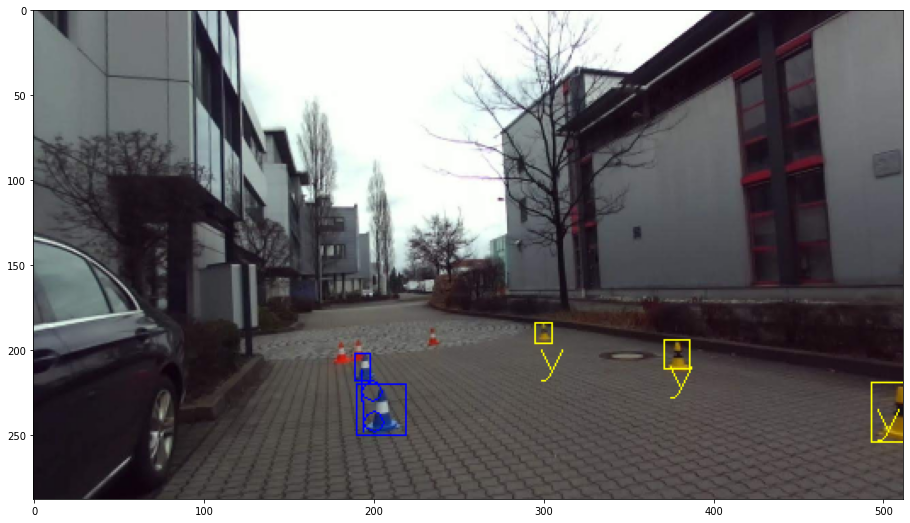

In [ ]:
import matplotlib.pyplot as plt
#print image transforming BGR-->GBR
plt.figure(figsize = (16,9))
imgplot = plt.imshow(img[...,::-1])


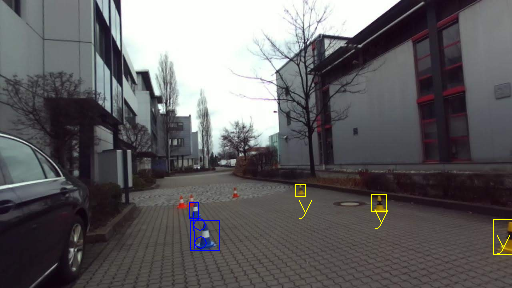

-1

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2.waitKey(0)
